In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Supervised Learning: Neural Networks

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import theano
import theano.tensor as T
from scipy import optimize
from ipywidgets import *
from IPython.display import SVG
from sklearn import datasets

theano.config.compute_test_value = 'ignore'

## McCulloch and Pitts Neuron

In 1943, McCulloch and Pitts introduced a mathematical model of a neuron. It consisted of three components:

1. A set of **weights** $w_i$ corresponding to synapses (inputs)
2. An **adder** for summing input signals; analogous to cell membrane that collects charge
3. An **activation function** for determining when the neuron fires, based on accumulated input

The neuron model is shown schematically below. On the left are input nodes $\{x_i\}$, usually expressed as a vector. The strength with which the inputs are able to deliver the signal along the synapse is determined by their corresponding weights $\{w_i\}$. The adder then sums the inputs from all the synapses:

$$h = \sum_i w_i x_i$$

The parameter $\theta$ determines whether or not the neuron fires given a weighted input of $h$. If it fires, it returns a value $y=1$, otherwise $y=0$. For example, a simple **activation function** is using $\theta$ as a simple fixed threshold:

$$y = g(h) = \left\{ \begin{array}{l}
1, \text{if } h \gt \theta \\
0, \text{if } h \le \theta
\end{array} \right.$$

this activation function may take any of several forms, such as a logistic function.

![neuron](http://d.pr/i/9AMK+)

A single neuron is not interesting, nor useful, from a learning perspective. It cannot learn; it simply receives inputs and either fires or not. Only when neurons are joined as a **network** can they perform useful work.

Learning takes place by changing the weights of the connections in a neural network, and by changing the parameters of the activation functions of neurons.

## Perceptron

A collection of McCullough and Pitts neurons, along with a set of input nodes connected to the inputs via weighted edges, is a perceptron, the simplest neural network.

Each neuron is independent of the others in the perceptron, in the sense that its behavior and performance depends only on its own weights and threshold values, and not of those for the other neurons. Though they share inputs, they operate independently.

The number of inputs and outputs are determined by the data. Weights are stored as a `N x K` matrix, with N observations and K neurons, with $w_{ij}$ specifying the weight on the *i*th observation on the *j*th neuron.

![perceptron](http://d.pr/i/4IWA+)

In order to use the perceptron for statistical learning, we compare the outputs $y_j$ from each neuron to the obervation target $t_j$, and adjust the input weights when they do not correspond (*e.g.* if a neuron fires when it should not have).

$$t_j - y_j$$

We use this difference to update the weight $w_{ij}$, based on the input and a desired **learning rate**. This results in an update rule:

$$w_{ij} \leftarrow w_{ij} + \eta (t_j - y_j) x_i$$

After an incremental improvement, the perceptron is shown the training data again, resulting in another update. This is repeated until the performance no longer improves. Having a learning rate less than one results in a more stable learning rate, though this stability is traded off against having to expose the network to the data multiple times. Typical learning rates are in the 0.1-0.4 range.

An additional input node is typically added to the perceptron model, which is a constant value (usually -1, 0, or 1) that acts analogously to an intercept in a regression model. This establishes a baseline input for the case when all inputs are zero.

![bias](http://d.pr/i/105b5+)

## Learning with Perceptrons

1. Initialize weights $w_{ij}$ to small, random numbers.
2. For each t in T iterations
    * compute activation for each neuron *j* connected to each input vector *i*
    $$y_j = g\left( h=\sum_i w_{ij} x_i \right) = \left\{ \begin{array}{l}
1, \text{if } h \gt 0 \\
0, \text{if } h \le 0
\end{array} \right.$$
    * update weights
    $$w_{ij} \leftarrow w_{ij} + \eta (t_j - y_j) x_i$$


This algorithm is $\mathcal{O}(Tmn)$

### Example: Logical functions

Let's see how the perceptron learns by training it on a couple of of logical functions, AND and OR. For two variables `x1` and `x2`, the AND function returns 1 if both are true, or zero otherwise; the OR function returns 1 if either variable is true, or both. These functions can be expressed as simple lookup tables.

In [3]:
AND = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,0,0,1)})
AND

,x1,x2,y
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,1


First, we need to initialize weights to small, random values (can be positive and negative).

In [4]:
w = np.random.randn(3)*1e-4

Then, a simple activation function for calculating $g(h)$:

In [5]:
g = lambda inputs, weights: np.where(np.dot(inputs, weights)>0, 1, 0)

Finally, a training function that iterates the learning algorithm, returning the adapted weights.

In [6]:
def train(inputs, targets, weights, eta, n_iterations):

    # Add the inputs that match the bias node
    inputs = np.c_[inputs, -np.ones((len(inputs), 1))]

    for n in range(n_iterations):

        activations = g(inputs, weights);
        weights -= eta*np.dot(np.transpose(inputs), activations - targets)
        
    return(weights)

Let's test it first on the AND function.

In [7]:
inputs = AND[['x1','x2']]
target = AND['y']

w = train(inputs, target, w, 0.25, 10)

Checking the performance:

In [8]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 0, 0, 1])

Thus, it has learned the function perfectly. Now for OR:

In [9]:
OR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,1)})
OR

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,1


In [10]:
w = np.random.randn(3)*1e-4

In [11]:
inputs = OR[['x1','x2']]
target = OR['y']

w = train(inputs, target, w, 0.25, 20)

In [12]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 1, 1, 1])

Also 100% correct.

### Exercise: XOR

Now try running the model on the XOR function, where a one is returned for either `x1` or `x2` being true, but *not* both. What happens here?

In [13]:
# Write your answer here

Let's explore the problem graphically:

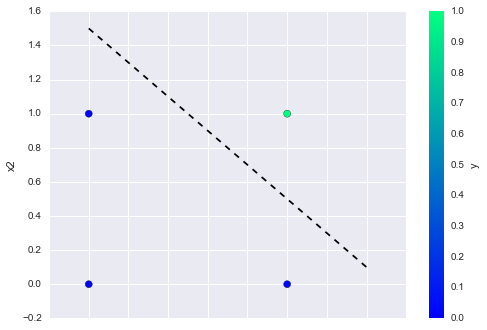

In [14]:
AND.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter')
plt.plot(np.linspace(0,1.4), 1.5 - 1*np.linspace(0,1.4), 'k--');

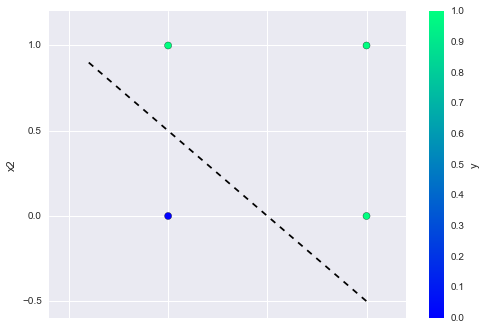

In [15]:
OR.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter')
plt.plot(np.linspace(-.4,1), .5 - 1*np.linspace(-.4,1), 'k--');

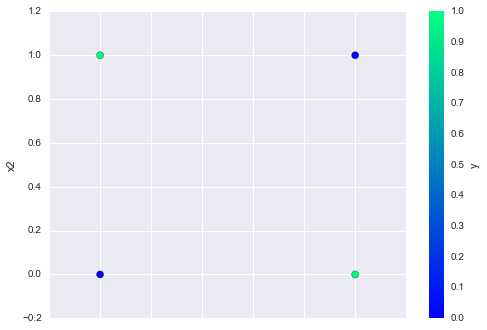

In [16]:
XOR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,0)})

XOR.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter');

The perceptron tries to find a separating hyperplane for the two response classes. Namely, a set of weights that satisfies:

$$\mathbf{x_1}\mathbf{w}^T=0$$

and:

$$\mathbf{x_2}\mathbf{w}^T=0$$

Hence,

$$\begin{aligned}
\mathbf{x}_1\mathbf{w}^T &= \mathbf{x}_2\mathbf{w}^T \\
\Rightarrow (\mathbf{x}_1 - \mathbf{x}_2) \mathbf{w}^T &= 0
\end{aligned}$$

This means that either the norms of $\mathbf{x}_1 - \mathbf{x}_2$ or $\mathbf{w}$ are zero, or the cosine of the angle between them is equal to zero, due to the identity:

$$\mathbf{a}\mathbf{b} = \|a\| \|b\| \cos \theta$$

Since there is no reason for the norms to be zero in general, we need the two vectors to be at right angles to one another. So, we need a weight vector that is perpendicular to the decision boundary.

Clearly, for the XOR function, the output classes are not linearly separable. So, the algorithm does not converge on an answer, but simply cycles through two incorrect solutions.

## Multi-layer Perceptron

The solution to fitting more complex (*i.e.* non-linear) models with neural networks is to use a more complex network that consists of more than just a single perceptron. The take-home message from the perceptron is that all of the learning happens by adapting the synapse weights until prediction is satisfactory. Hence, a reasonable guess at how to make a perceptron more complex is to simply **add more weights**.

There are two ways to add complexity:

1. Add backward connections, so that output neurons feed back to input nodes, resulting in a **recurrent network**
2. Add neurons between the input nodes and the outputs, creating an additional ("hidden") layer to the network, resulting in a **multi-layer perceptron**

The latter approach is more common in applications of neural networks.

![multilayer](http://d.pr/i/14BS1+)

How to train a multilayer network is not intuitive. Propagating the inputs forward over two layers is straightforward, since the outputs from the hidden layer can be used as inputs for the output layer. However, the process for updating the weights based on the prediction error is less clear, since it is difficult to know whether to change the weights on the input layer or on the hidden layer in order to improve the prediction.

Updating a multi-layer perceptron (MLP) is a matter of: 

1. moving forward through the network, calculating outputs given inputs and current weight estimates
2. moving backward updating weights according to the resulting error from forward propagation. 

In this sense, it is similar to a single-layer perceptron, except it has to be done twice, once for each layer (in principle, we can add additional hidden layers, but without sacrificing generality, I will keep it simple).

### Error back-propagation

We update the weights in a MLP using **back-propagation** of the prediction errors, which is essentially a form of gradient descent, as we have used previously for optimization.

First, for the multi-layer perceptron we need to modify the error function, which in the single-layer case was a simple difference between the predicted and observed outputs. Because we will be summing errors, we have to avoid having errors in different directions cancelling each other out, so a sum of squares error is more appropriate:

$$E(t,y) = \frac{1}{2} \sum_i (t_i - y_i)^2$$

It is on this function that we will perform gradient descent, since the goal is to minimize the error. Specificially, we will differentiate with respect to the weights, since it is the weights that we are manipulating in order to get better predictions.

Recall that the error is a function of the threshold function

$$E(\mathbf{w}) = \frac{1}{2} \sum_i (t_i - y_i)^2 = \frac{1}{2} \sum_i \left(t_i - g\left[ \sum_j w_{ij} a_j \right]\right)^2$$

So, we will also need to differentiate that. However, the threshold function we used in the single-layer perceptron was discontinuous, making it non-differentiable. Thus, we need to modify it as well. An alternative is to employ some type of sigmoid function, such as the logistic, which can be parameterized to resemble a threshold function, but varies smoothly across its range.

$$g(h) = \frac{1}{1 + \exp(-\beta h)}$$

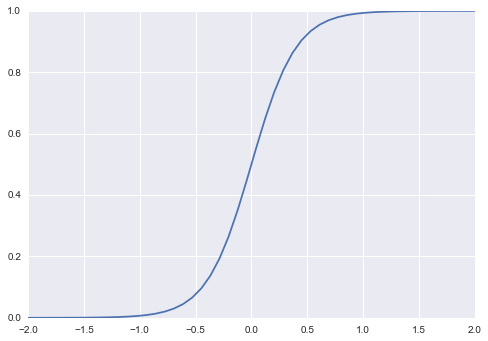

In [48]:
logistic = lambda h, beta: 1./(1 + np.exp(-beta * h))

@interact(beta=(-1, 25))
def logistic_plot(beta=5):
    hvals = np.linspace(-2, 2)
    plt.plot(hvals, logistic(hvals, beta))

This has the advantage of having a simple derivative:

$$\frac{dg}{dh} = \beta g(h)(1 - g(h))$$

Alternatively, the hyperbolic tangent function is also sigmoid:

$$g(h) = \tanh(h) = \frac{\exp(h) - \exp(-h)}{\exp(h) + \exp(-h)}$$

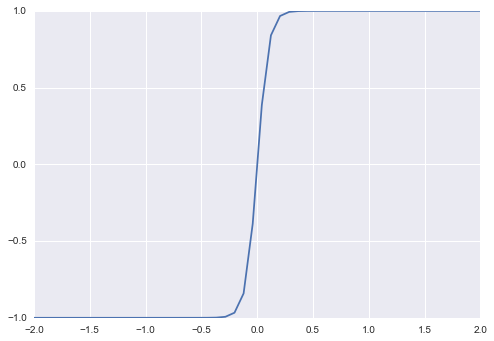

In [49]:
hyperbolic_tangent = lambda h: (np.exp(h) - np.exp(-h)) / (np.exp(h) + np.exp(-h))

@interact(theta=(-1, 25))
def tanh_plot(theta=5):
    hvals = np.linspace(-2, 2)
    h = hvals*theta
    plt.plot(hvals, hyperbolic_tangent(h))

Notice that the hyperbolic tangent function asymptotes at -1 and 1, rather than 0 and 1, which is sometimes beneficial, and its derivative is simple:

$$\frac{d \tanh(x)}{dx} = 1 - \tanh^2(x)$$

Performing gradient descent will allow us to change the weights in the direction that optimially reduces the error. The next trick will be to employ the **chain rule** to decompose how the error changes as a function of the input weights into the change in error as a function of changes in the inputs to the weights, mutliplied by the changes in input values as a function of changes in the weights. 

$$\frac{\partial E}{\partial w} = \frac{\partial E}{\partial h}\frac{\partial h}{\partial w}$$

This will allow us to write a function describing the activations of the output weights as a function of the activations of the hidden layer nodes and the output weights, which will allow us to propagate error backwards through the network.

The second term in the chain rule simplifies to:

$$\begin{align}
\frac{\partial h_k}{\partial w_{jk}} &= \frac{\partial \sum_l w_{lk} a_l}{\partial w_{jk}}  \\
&= \sum_l \frac{\partial w_{lk} a_l}{\partial w_{jk}} \\
& = a_j
\end{align}$$

where $a_j$ is the activation of the jth hidden layer neuron.

For the first term in the chain rule above, we decompose it as well:

$$\frac{\partial E}{\partial h_k} = \frac{\partial E}{\partial y_k}\frac{\partial y_k}{\partial h_k} = \frac{\partial E}{\partial g(h_k)}\frac{\partial g(h_k)}{\partial h_k}$$

The second term of this chain rule is just the derivative of the activation function, which we have chosen to have a conveneint form, while the first term simplifies to:

$$\frac{\partial E}{\partial g(h_k)} = \frac{\partial}{\partial g(h_k)}\left[\frac{1}{2} \sum_k (t_k - y_k)^2 \right] = t_k - y_k$$

Combining these, and assuming (for illustration) a logistic activiation function, we have the gradient:

$$\frac{\partial E}{\partial w} = (t_k - y_k) y_k (1-y_k) a_j$$

Which ends up getting plugged into the weight update formula that we saw in the single-layer perceptron:

$$w_{jk} \leftarrow w_{jk} - \eta (t_k - y_k) y_k (1-y_k) a_j$$

Note that here we are *subtracting* the second term, rather than adding, since we are doing gradient descent.

We can now outline the MLP learning algorithm:

1. Initialize all $w_{jk}$ to small random values
2. For each input vector, conduct forward propagation:
    * compute activation of each neuron $j$ in hidden layer (here, sigmoid):
    $$h_j = \sum_i x_i v_{ij}$$
    $$a_j = g(h_j) = \frac{1}{1 + \exp(-\beta h_j)}$$
    * when the output layer is reached, calculate outputs similarly:
    $$h_k = \sum_k a_j w_{jk}$$
    $$y_k = g(h_k) = \frac{1}{1 + \exp(-\beta h_k)}$$
3. Calculate loss for resulting predictions:
    * compute error at output:
    $$\delta_k = (t_k - y_k) y_k (1-y_k)$$
4. Conduct backpropagation to get partial derivatives of cost with respect to weights, and use these to update weights:
    * compute error of the hidden layers:
    $$\delta_{hj} = \left[\sum_k w_{jk} \delta_k \right] a_j(1-a_j)$$
    * update output layer weights:
    $$w_{jk} \leftarrow w_{jk} - \eta \delta_k a_j$$
    * update hidden layer weights:
    $$v_{ij} \leftarrow v_{ij} - \eta \delta_{hj} x_i$$
    
Return to (2) and iterate until learning completes. Best practice is to shuffle input vectors to avoid training in the same order.

Its important to be aware that because gradient descent is a hill-climbing (or descending) algorithm, it is liable to be caught in local minima with respect to starting values. Therefore, it is worthwhile training several networks using a range of starting values for the weights, so that you have a better chance of discovering a globally-competitive solution.

One useful performance enhancement for the MLP learning algorithm is the addition of **momentum** to the weight updates. This is just a coefficient on the previous weight update that increases the correlation between the current weight and the weight after the next update. This is particularly useful for complex models, where falling into local mimima is an issue; adding momentum will give some weight to the previous direction, making the resulting weights essentially a weighted average of the two directions. Adding momentum, along with a smaller learning rate, usually results in a more stable algorithm with quicker convergence. When we use momentum, we lose this guarantee, but this is generally seen as a small price to pay for the improvement momentum usually gives.

A weight update with momentum looks like this:

$$w_{jk} \leftarrow w_{jk} - \eta \delta_k a_j + \alpha \Delta w_{jk}^{t-1}$$

where $\alpha$ is the momentum (regularization) parameter and $\Delta w_{jk}^{t-1}$ the update from the previous iteration.

The multi-layer pereptron is implemented below in the `MLP` class. The implementation uses the scikit-learn interface, so it is uses in the same way as other supervised learning algorithms in that package.

In [19]:
softmax = lambda a: a / np.sum(a, axis=1, keepdims=True)

class MLP:
    
    def __init__(self, alpha=0.01, eta=0.01, n_hidden_dim=25):
        
        self.alpha = alpha
        self.eta = eta
        self.n_hidden_dim = n_hidden_dim
        
    # Helper function to evaluate the total loss on the dataset
    def calculate_loss(self, X, y):
        
        # Forward propagation to calculate our predictions
        z1 = X.dot(self.w1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.w2) + self.b2
        exp_scores = np.exp(z2)
        probs = softmax(exp_scores)
        
        # Calculating the loss
        data_loss = -np.log(probs[range(num_examples), y]).sum()
        
        # Add regulatization term to loss (optional)
        data_loss += self.alpha/2 * np.square(self.w1).sum() + np.square(self.w2).sum()
        
        return 1./num_examples * data_loss
        
    # Helper function to predict an output (0 or 1)
    def predict(self, x):

        # Forward propagation
        z1 = x.dot(self.w1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.w2) + self.b2
        exp_scores = np.exp(z2)
        probs = softmax(exp_scores)
        
        return np.argmax(probs, axis=1)
        
        
    def fit(self, X, y, num_passes=20000, print_loss=False, seed=42):
        
        num_examples, nn_input_dim = X.shape
        nn_output_dim = len(set(y))
    
        # Initialize the parameters to random values. We need to learn these.
        np.random.seed(seed)
        self.w1 = np.random.randn(nn_input_dim, self.n_hidden_dim) / np.sqrt(nn_input_dim)
        self.b1 = np.zeros((1, self.n_hidden_dim))
        self.w2 = np.random.randn(self.n_hidden_dim, nn_output_dim) / np.sqrt(self.n_hidden_dim)
        self.b2 = np.zeros((1, nn_output_dim))


        # Gradient descent. For each batch...
        for i in range(num_passes):

            # Forward propagation
            z1 = X.dot(self.w1) + self.b1
            a1 = np.tanh(z1)
            z2 = a1.dot(self.w2) + self.b2
            exp_scores = np.exp(z2)

            # Backpropagation
            delta3 = softmax(exp_scores)
            delta3[range(num_examples), y] -= 1
            dw2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(self.w2.T) * (1 - np.power(a1, 2))
            dw1 = np.dot(X.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dw2 += self.alpha * self.w2
            dw1 += self.alpha * self.w1

            # Gradient descent parameter update
            self.w1 += -self.eta * dw1
            self.b1 += -self.eta * db1
            self.w2 += -self.eta * dw2
            self.b2 += -self.eta * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
              print("Loss after iteration %i: %f" %(i, calculate_loss(X, y)))


Let's initialize a MLP classifier, specifying the conjugate gradient minimization method.

In [20]:
mlp = MLP()

Now we can confirm that it solves a non-linear classification, using the simple XOR example

In [21]:
X = XOR[['x1','x2']].values
y = XOR['y'].values

In [22]:
mlp.fit(X, y, num_passes=100)

In [23]:
mlp.predict(X)

array([0, 1, 1, 0])

For a somewhat more sophisiticated example, we can use scikit-learn to simulate some data with a non-linear boundary.

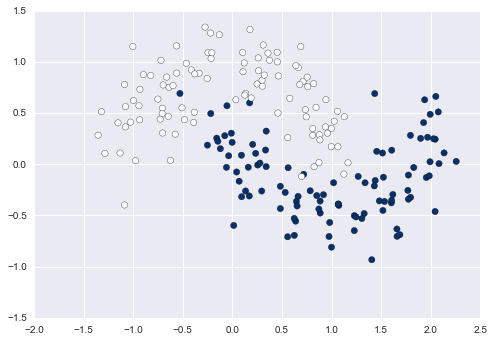

In [58]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = datasets.make_moons(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Blues)

In [25]:
clf = MLP(n_hidden_dim=3)
clf.fit(train_X, train_y)

In [56]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Blues)

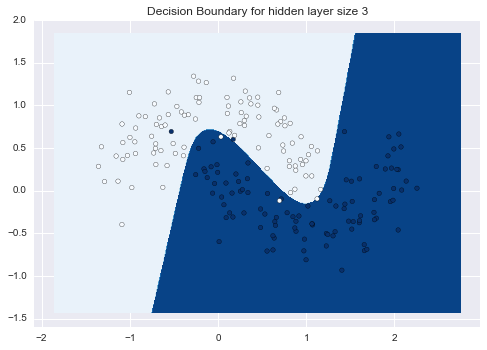

In [57]:
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Decision Boundary for hidden layer size 3")

Since we used the scikit-learn interface, its easy to take advantage of the `metrics` module to evaluate the MLP's performance.

In [28]:
test_X, test_y = datasets.make_moons(50, noise=0.20)
test_X = test_X.astype(np.float32)
test_y = test_y.astype(np.int32)

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(test_y, clf.predict(test_X))

0.97999999999999998

In [30]:
confusion_matrix(test_y, clf.predict(test_X))

array([[25,  0],
       [ 1, 24]])

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.

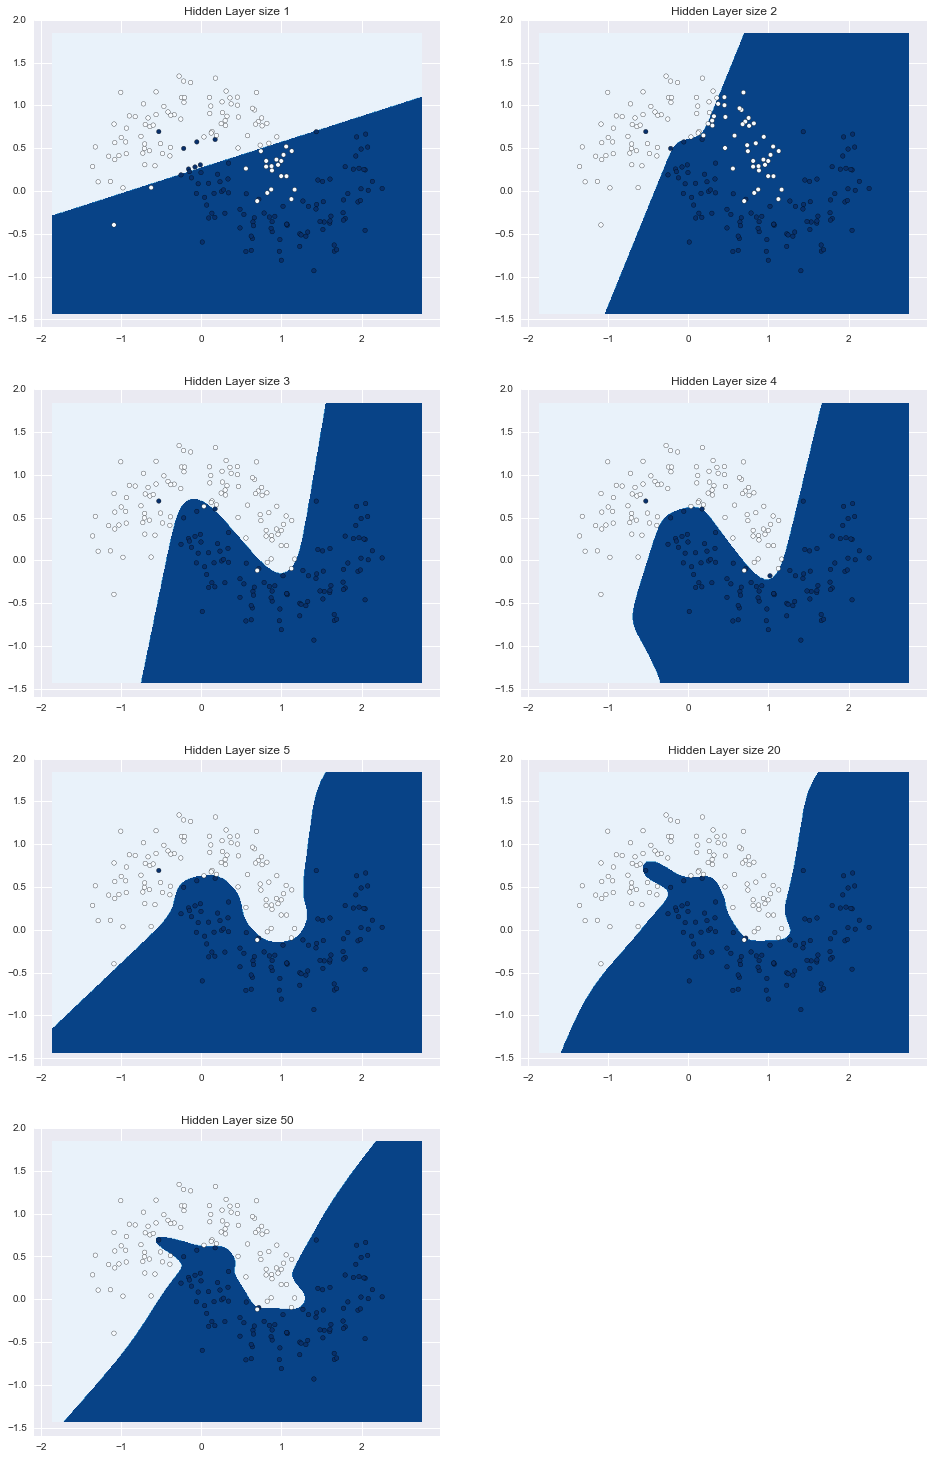

In [59]:
plt.figure(figsize=(16, 32))
n_hidden_dim = [1, 2, 3, 4, 5, 20, 50]
for i, h in enumerate(n_hidden_dim):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % h)
    model = MLP(n_hidden_dim=h)
    model.fit(train_X, train_y)
    plot_decision_boundary(lambda x: model.predict(x))

### Neural network specification

The MLP implemented above uses a single hidden layer, though it allows a user-specified number of hidden layer nodes (defaults to 25). It is worth considering whether it is useful having **multiple hidden layers**, and whether more hidden nodes is desirable.

Unfortunately, there is no theory to guide the choice of hidden node number. As a result, we are left to experiment with this parameter, perhaps in some systematic fashion such as cross-validation.

Adding additional layers presents only additional "bookkeeping" overhead to the user, with the weight updating becoming more complicated as layers are added. So, we don't want to add more hidden layers if it does not pay off in performance. It turns out that two or three layers (including the output layer) can be shown to approximate almost any smooth function. Combining 3 sigmoid functions allows local responses to be approximated with arbitrary accuracy. This is sufficient for determining any decision boundary.

### Neural network validation

Just as with other supervised learning algorithms, neural networks can be under- or over-fit to a training dataset. The degree to which a network is trained to a particular dataset depends on how long we train it on that dataset. Every time we run the MLP learning algorithm over a dataset (an **epoch**), it reduces the prediction error for that dataset. Thus, the number of epochs should be tuned as a hyperparameter, stopping when the testing-training error gap begins to widen.

Note that though we can also use cross-validation to tune the number of hidden layers in the network, there is no risk of overfitting by having too many layers.

### Exercise: Epoch tuning for MLPs

The dataset `pima-indians-diabetes.data.txt` in your data folder contains eight measurements taken from a group of Pima Native Americans in Arizona, along with an indicator of the onset of diabetes. Use the MLP class to fit a neural network classifier to this dataset, and use cross-validation to examine the optimal number of epochs to use in training.

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

In [32]:
pima = pd.read_csv('../data/pima-indians-diabetes.data.txt', header=None)
pima.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [33]:
# Write your answer here

## Example: Mulitilayer perceptron in Theano

Recall the Theano package, introduced earlier in the course; it is designed to evaluate expressions efficiently, and one of its key features is that it automatically differentiates expressions. This saves us from having to code a gradient function by hand. In principle, we could also use Theano to parallelize a neural network using GPUs, but we will not explore that here.

In [34]:
# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 100 # hiden layer dimensionality

# Gradient descent parameters (I picked these by hand)
eta = 0.01 # learning rate for gradient descent
alpha = 0.01 # regularization strength 

## Defining the Computation Graph in Theano

The first thing we need to is define our computations using Theano. We start by defining our input data matrix `X` and our training labels `y`:

In [35]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

Remember, we have not assigned any values to `X` or `y`. All we have done is defined mathematical expressions for them. We can use these expressions in subsequent calculations. If we want to evaluate an expression we can call its `eval` method. For example, to evaluate the expression `X * 2` for a given value of `X` we could do the following:

In [36]:
(X * 2).eval({X : [[1,1],[2,2]] })

array([[ 2.,  2.],
       [ 4.,  4.]])

Recall also that in addition to tensor objects, Theano also has shared variables which have values associated with them. Their value that is kept in memory and can be shared by all functions that use them. Shared variables can also be updated, and Theano includes low-level optimizations that makes updating them very efficient, especially on GPUs. Our network parameters $W_1, b_1, W_2, b_2$ are constantly updated using gradient descent, so they can be represented by shared variables:

In [37]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

Our definition of forward propagation in Theano is identical to our pure Python implementation, except that we now define Theano expressions. 

In [38]:
# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * alpha/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

Rather than calling the `eval` method to evaluate our Theano expressions, we can instead define Theano functions for expressions we want to evaluate. To create a function we need to define its inputs and outputs. For example, to calculate the loss, we need to know the values for $X$ and $y$. Once created, we can call it function just like any other Python function.

In [39]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Example call: Forward Propagation
forward_prop([[1,2]])

array([[ 0.99680404,  0.00319596]])

To get a sense of how Theano constructs a computational graph, we can generate a graphic of the expression tree. Looking at the expressions for $\hat{y}$, we can see that it depends on $z2$, which in turn depends on $a_1$, $W_2$ and $b_2$, and so on.

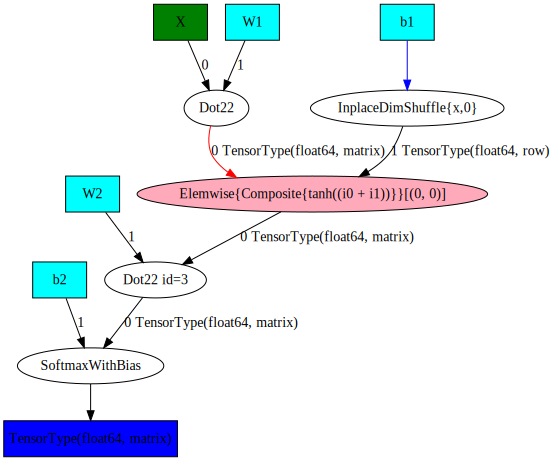

In [40]:
SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, 
                               compact=True, return_image=True, format='svg'))

This is the *optimized* computational graph that Theano has constructed for our `forward_prop` function. We can also get a textual description:

In [41]:
theano.printing.debugprint(forward_prop)

SoftmaxWithBias [id A] ''   4
 |Dot22 [id B] ''   3
 | |Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [id C] ''   2
 | | |Dot22 [id D] ''   1
 | | | |X [id E]
 | | | |W1 [id F]
 | | |InplaceDimShuffle{x,0} [id G] ''   0
 | |   |b1 [id H]
 | |W2 [id I]
 |b2 [id J]


What's left is defining the updates to the network parameters we use with gradient descent. We previously calculated the gradients using backpropagation. Since Theano can automatically differentiate functions for us, we do not have to code them by hand. We need the derivates of our loss function $L$ with respect to our parameters: $\frac{\partial L}{\partial W_2}$, $\frac{\partial L}{\partial b_2}$, $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$:

In [42]:
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

Because we defined $W_2, b_2, W_1, b_1$ as shared variables we can use Theano's update mechanism to update their values. The following function (without return value) does a single gradient descent update given $X$ and $y$ as inputs:

In [43]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - eta * dW2),
             (W1, W1 - eta * dW1),
             (b2, b2 - eta * db2),
             (b1, b1 - eta * db1)))

Note that we don't need to explicitly do a forward propagation here. Theano knows that our gradients depend on our predictions from the forward propagation and it will handle all the necessary calculations for us. It does everything it needs to update the values.

Let's now define a function to train a Neural Network using gradient descent. Again, it's equivalent to what we had in our original code, only that we are now calling the `gradient_step` function defined above instead of doing the calculations ourselves.

In [44]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))

In [45]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

Loss after iteration 0: 0.667974
Loss after iteration 1000: 0.296073
Loss after iteration 2000: 0.277811
Loss after iteration 3000: 0.258882
Loss after iteration 4000: 0.237967
Loss after iteration 5000: 0.217021
Loss after iteration 6000: 0.197847
Loss after iteration 7000: 0.181274
Loss after iteration 8000: 0.167443
Loss after iteration 9000: 0.156112
Loss after iteration 10000: 0.146876
Loss after iteration 11000: 0.139313
Loss after iteration 12000: 0.133055
Loss after iteration 13000: 0.127804
Loss after iteration 14000: 0.123331
Loss after iteration 15000: 0.119459
Loss after iteration 16000: 0.116057
Loss after iteration 17000: 0.113026
Loss after iteration 18000: 0.110291
Loss after iteration 19000: 0.107797


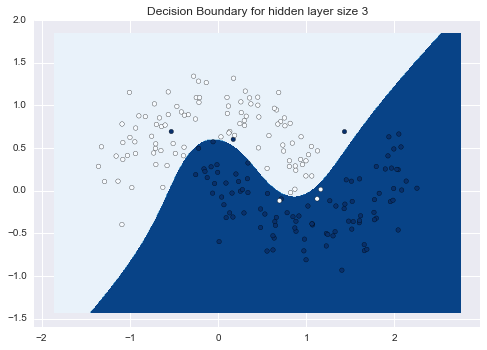

In [60]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary for hidden layer size 3")

## References

T. Hastie, R. Tibshirani and J. Friedman. (2009) [Elements of Statistical Learning: Data Mining, Inference, and Prediction](http://statweb.stanford.edu/~tibs/ElemStatLearn/), second edition. Springer.

S. Marsland. (2009) [Machine Learning: An Algorithmic Perspective](Machine Learning: An Algorithmic Perspectivehttp://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html). CRC Press.

D. Rodriguez. (2013) [Basic [1 hidden layer] neural network on Python](http://danielfrg.com/blog/2013/07/03/basic-neural-network-python/).

D. Britz. (2015) [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)